In [1]:
import tensorflow as tf
import os

In [2]:
# Stops out of memory error
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    # Tells TF not to use all of memory
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data'

In [6]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [8]:
# This allows for the building of a data pipeline
# ?? shows the documentation
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
@six.add_metaclass(abc.ABCMeta)
class DatasetV2(collections_abc.Iterable, tracking_base.Trackable,
                composite_tensor.CompositeTensor):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dtype=int32)
  tf.Ten

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


2022-07-13 16:42:50.665007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 16:42:51.243000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78916 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4d:00.0, compute capability: 8.0


In [11]:
data.class_names

['happy', 'sad']

In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

In [14]:
batch[0].shape

(32, 256, 256, 3)

In [15]:
batch[1]

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

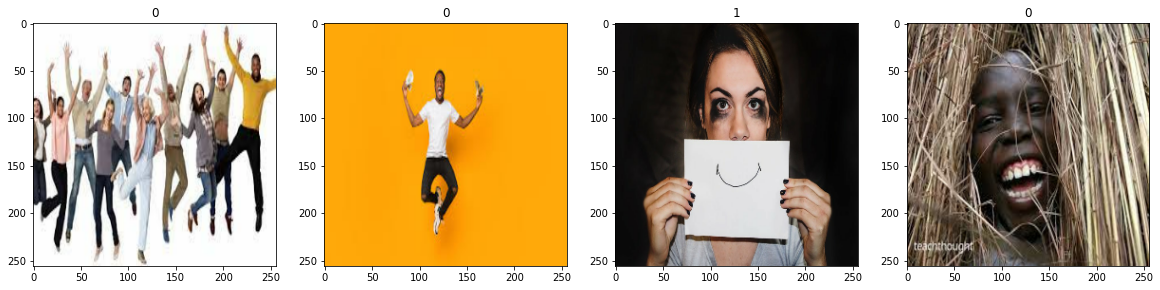

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [17]:
# Scale Data
data = data.map(lambda x, y: (x/255, y)) 

In [18]:
scaled_iterator = data.as_numpy_iterator()

In [19]:
batch = scaled_iterator.next()

In [20]:
batch[0].min()

0.0

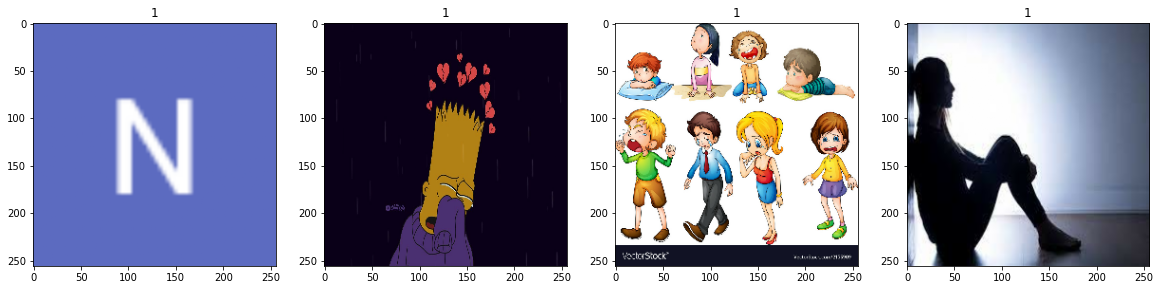

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [22]:
len(data)

10

In [23]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [24]:
train_size+test_size+val_size

10

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [35]:
model = Sequential()

In [36]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [37]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [39]:
logdir='logs'

In [41]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [42]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2022-07-13 16:45:55.920638: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-07-13 16:45:57.064352: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7/7 [==============================] - 5s 149ms/step - loss: 0.7398 - accuracy: 0.5223 - val_loss: 0.6515 - val_accuracy: 0.4688
Epoch 2/20
7/7 [==============================] - 1s 129ms/step - loss: 0.6187 - accuracy: 0.6027 - val_loss: 0.5847 - val_accuracy: 0.5938
Epoch 3/20
7/7 [==============================] - 1s 113ms/step - loss: 0.5864 - accuracy: 0.6741 - val_loss: 0.5001 - val_accuracy: 0.7812
Epoch 4/20
7/7 [==============================] - 1s 117ms/step - loss: 0.5043 - accuracy: 0.7946 - val_loss: 0.3851 - val_accuracy: 0.9531
Epoch 5/20
7/7 [==============================] - 1s 113ms/step - loss: 0.4038 - accuracy: 0.8080 - val_loss: 0.2797 - val_accuracy: 0.9375
Epoch 6/20
7/7 [==============================] - 1s 110ms/step - loss: 0.2962 - accuracy: 0.9107 - val_loss: 0.1795 - val_accuracy: 0.9531
Epoch 7/20
7/7 [==============================] - 1s 113ms/step - loss: 0.2289 - accuracy: 0.9241 - val_loss: 0.1423 - val_accuracy: 0.9688
Epoch 8/20
7/7 [===============

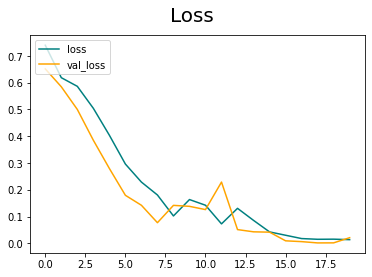

In [44]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

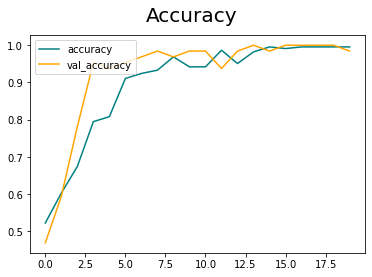

In [45]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [46]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [47]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [48]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 234ms/step


In [49]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


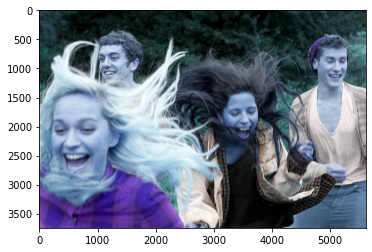

In [52]:
img = cv2.imread('data/happy/154006829.jpg')
plt.imshow(img)
plt.show()

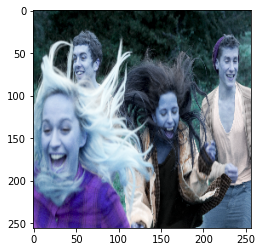

In [53]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [54]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 72ms/step


In [55]:
yhat

array([[0.03967255]], dtype=float32)

In [56]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


In [57]:
from tensorflow.keras.models import load_model

In [58]:
model.save(os.path.join('models','imageclassifier.h5'))

In [60]:
new_model = load_model('models/imageclassifier.h5')

In [61]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 83ms/step


array([[0.03967255]], dtype=float32)